## Importing Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.utils import resample

import re

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

from tensorflow import keras
from keras import layers

from keras.utils.vis_utils import plot_model

%matplotlib inline

## Data Preparation

In [5]:
data=pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [6]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Checking for bias

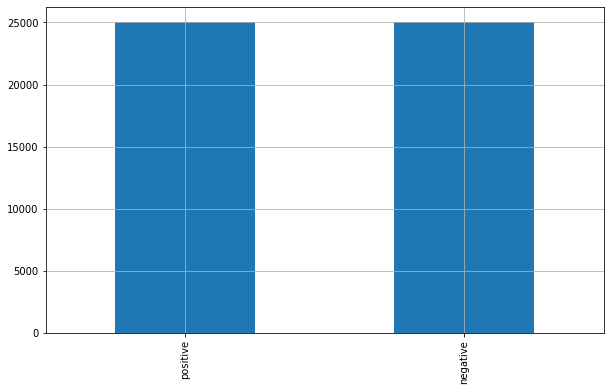

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [7]:
data['sentiment'].value_counts().plot(kind='bar',figsize=(10,6),grid='-')
plt.show()
data['sentiment'].value_counts()

In [8]:
# unbiased distribution

## Data Processing

In [17]:
x,y=data['review'],data['sentiment']

In [18]:
# data cleaning
pattern = "[^a-zA-Z0-9$,.]"
x = [re.sub(pattern," ",sentence).lower().strip() for sentence in x]

def prepare_data(df):
    data=df['review']
    useless_words=list(stopwords.words('english'))+list(punctuation)
    
    lemmatizer=WordNetLemmatizer()
    corpus=data.tolist()
    final_corpus=[]
    
    for i in range(len(corpus)):
        word=word_tokenize(corpus[i].lower())
        word=[
            lemmatizer.lemmatize(y) for y in word if y not in useless_words
        ]
        j=" ".join(word)
        final_corpus.append(j)
    
    return final_corpus

In [19]:
x={'review':x}
x=pd.DataFrame(x)
x.head()

,review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production. br br the...
2,i thought this was a wonderful way to spend ti...
3,basically there s a family where a little boy ...
4,petter mattei s love in the time of money is...


In [20]:
final_corpus=prepare_data(data)

le=LabelEncoder()
data['sentiment']=le.fit_transform(data['sentiment'])

train_df={
    'review':final_corpus,
    'sentiment':data['sentiment']
}

train_df=pd.DataFrame(train_df)
train_df.head()

,review,sentiment
0,one reviewer mentioned watching 1 oz episode '...,1
1,wonderful little production br br filming tech...,1
2,thought wonderful way spend time hot summer we...,1
3,basically 's family little boy jake think 's z...,0
4,petter mattei 's `` love time money '' visuall...,1


## Data Preparation

In [21]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['review'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 101821 unique tokens.


In [22]:
X = tokenizer.texts_to_sequences(train_df['review'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (50000, 250)


In [23]:
Y = pd.get_dummies(train_df['sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (50000, 2)


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(40000, 250) (40000, 2)
(10000, 250) (10000, 2)


## LSTM Model

In [28]:
model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))
model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs,steps_per_epoch=100, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
100/100 [==============================] - 56s 539ms/step - loss: 0.5406 - accuracy: 0.7241 - val_loss: 0.3603 - val_accuracy: 0.8420
Epoch 2/5
100/100 [==============================] - 54s 537ms/step - loss: 0.3356 - accuracy: 0.8597 - val_loss: 0.3039 - val_accuracy: 0.8739
Epoch 3/5
100/100 [==============================] - 56s 562ms/step - loss: 0.3582 - accuracy: 0.8512 - val_loss: 0.3379 - val_accuracy: 0.8545
Epoch 4/5
100/100 [==============================] - 54s 542ms/step - loss: 0.3188 - accuracy: 0.8692 - val_loss: 0.3444 - val_accuracy: 0.8649
Epoch 5/5
100/100 [==============================] - 54s 543ms/step - loss: 0.2892 - accuracy: 0.8869 - val_loss: 0.2789 - val_accuracy: 0.8866


In [44]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 100)          5000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 248, 100)          30100     
_________________________________________________________________
dense_8 (Dense)              (None, 248, 2)            202       
Total params: 5,030,302
Trainable params: 5,030,302
Non-trainable params: 0
_________________________________________________________________


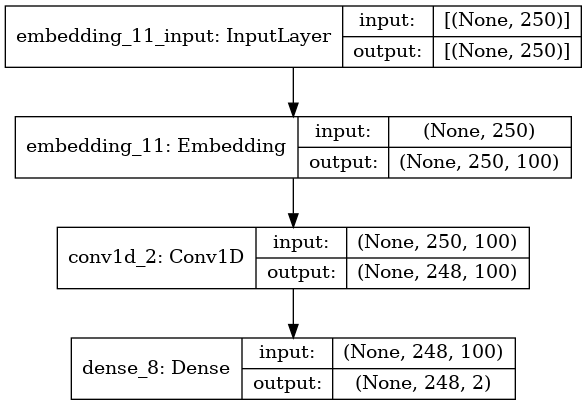

In [45]:
plot_model(model,show_shapes=True,show_layer_names=True)

## Results

In [29]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

313/313 [==============================] - 20s 64ms/step - loss: 0.2639 - accuracy: 0.8952
Test set
  Loss: 0.264
  Accuracy: 0.895


In [32]:
def get_plot(trained_model,no_epochs):
    accuracy=trained_model.history['accuracy']
    loss=trained_model.history['loss']
    val_accuracy=trained_model.history['val_accuracy']
    val_loss=trained_model.history['val_loss']
    epochs=[i for i in range(1,no_epochs+1)]

    plt.figure(figsize=(12,8))
    plt.plot(epochs,accuracy,'r',label='Training')
    plt.plot(epochs,val_accuracy,'--',label='Validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy',fontsize=15)
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(epochs,loss,'r',label='Training')
    plt.plot(epochs,val_loss,'--',label='Validation')
    plt.legend()
    plt.title('Loss',fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

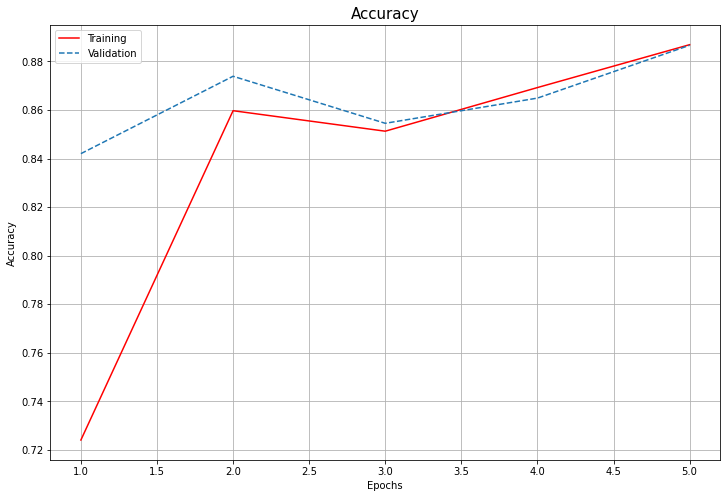

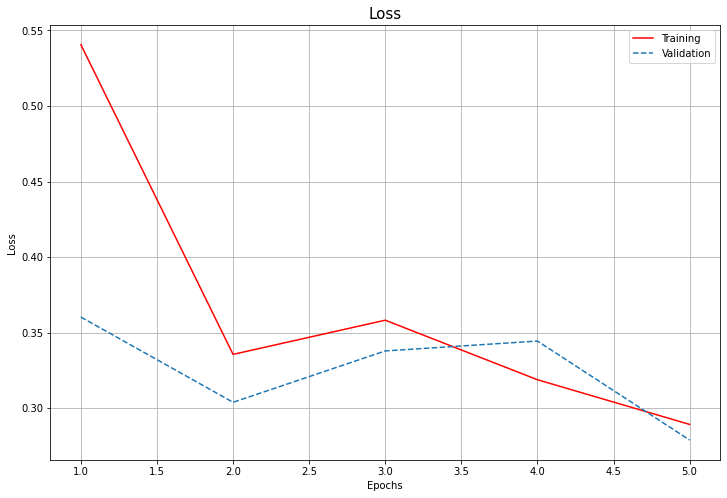

In [33]:
get_plot(history,5)